# Going Deeper CV 2. VGG Ablation Study

## Ablation study

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시한다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교한다.  

애블레이션 연구란 이처럼 __"아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험__이다.

CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인해보자.

## 1. 데이터 준비
CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel) 이다.  

CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠다.

```
pip install tensorflow-datasets
```

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않는다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등의 정보를 확인할 수 있다.

모델에 넣어주기 전에는 각 채널별 최댓값인 255로 __정규화(normalize)__를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만든다.

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가진다. 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해보자.

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

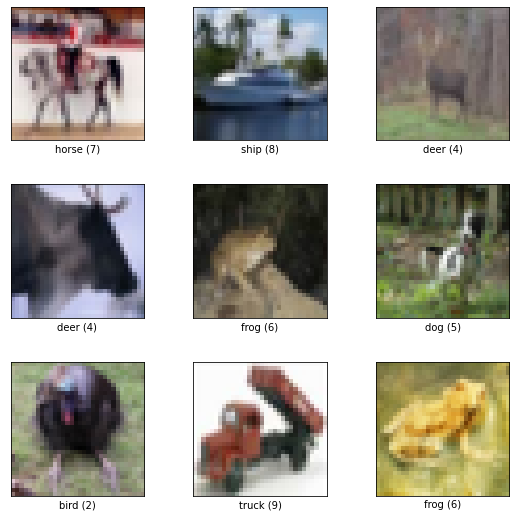

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

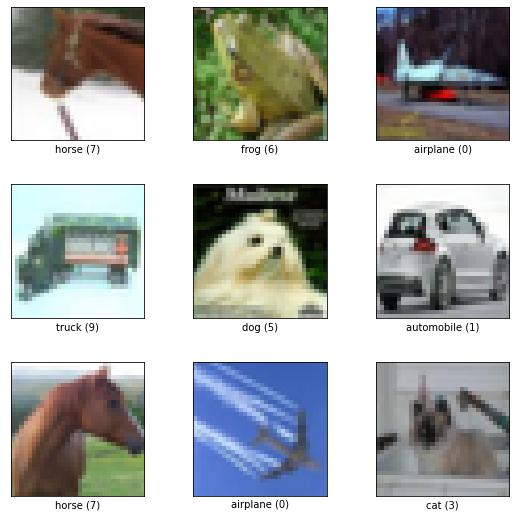

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요하다.

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라고 부른다. 레이어(layer) 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위이다. 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야한다.

ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해 보겠다.

## VGG 기본 블록 만들기
![image](https://user-images.githubusercontent.com/84179578/134896993-df9541da-bd74-434c-9a2c-2d4678f69eaf.png)
VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해보자.  

블록을 구현하기 위한 모델 구조의 특징은 아래와 같다.  
- VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어진다. 
- CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있다. 
- 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다. 블록에 따라서 CNN 레이어의 개수 또한 달라진다. 
- 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야한다.

`block_num`은 레이어의 이름을 붙여주기 위해서 추가되었고 `input_shape`는 summary를 출력하기 위해서 넣어주었다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 input_layer 에 추가를 해보자. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 (32,32,3) 이 된다.  
이 입력 레이어를 인자로 받아 `build_vgg_block()`는 블록의 레이어를 build하고 출력값을 얻을 수 있다. 이제 케라스의 Model 클래스에서 input과 output을 정의해 주면 간단히 블록의 모델을 확인해볼 수 있다.

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## VGG-16

먼저 작은 네트워크인 VGG-16을 먼저 만들어 보겠다. 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 이는 VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달되어야한다. 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달했다.

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## VGG-19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 모델 훈련 및 평가

In [18]:
BATCH_SIZE = 256
EPOCH = 20

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### VGG16 훈련

In [20]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 206s 902ms/step - loss: 2.2369 - accuracy: 0.1631 - val_loss: 2.0521 - val_accuracy: 0.2508
Epoch 2/20
195/195 [==============================] - 185s 951ms/step - loss: 2.0030 - accuracy: 0.2741 - val_loss: 1.8958 - val_accuracy: 0.3168
Epoch 3/20
195/195 [==============================] - 169s 866ms/step - loss: 1.8615 - accuracy: 0.3300 - val_loss: 1.7368 - val_accuracy: 0.3786
Epoch 4/20
195/195 [==============================] - 168s 862ms/step - loss: 1.7398 - accuracy: 0.3726 - val_loss: 1.6921 - val_accuracy: 0.4013
Epoch 5/20
195/195 [==============================] - 169s 866ms/step - loss: 1.6547 - accuracy: 0.4054 - val_loss: 1.6274 - val_accuracy: 0.4182
Epoch 6/20
195/195 [==============================] - 167s 859ms/step - loss: 1.5879 - accuracy: 0.4286 - val_loss: 1.5832 - val_accuracy: 0.4415
Epoch 7/20
195/195 [==============================] - 169s 866ms/step - loss: 1.5455 - accuracy: 0.4463 - val_loss: 1.5137 -

#### VGG19 훈련

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 203s 1s/step - loss: 2.2701 - accuracy: 0.1397 - val_loss: 2.0906 - val_accuracy: 0.2423
Epoch 2/20
195/195 [==============================] - 198s 1s/step - loss: 2.0694 - accuracy: 0.2400 - val_loss: 1.9681 - val_accuracy: 0.2847
Epoch 3/20
195/195 [==============================] - 198s 1s/step - loss: 1.9316 - accuracy: 0.2963 - val_loss: 1.7976 - val_accuracy: 0.3508
Epoch 4/20
195/195 [==============================] - 198s 1s/step - loss: 1.8175 - accuracy: 0.3389 - val_loss: 1.7420 - val_accuracy: 0.3689
Epoch 5/20
195/195 [==============================] - 197s 1s/step - loss: 1.7240 - accuracy: 0.3758 - val_loss: 1.6445 - val_accuracy: 0.4123
Epoch 6/20
195/195 [==============================] - 198s 1s/step - loss: 1.6407 - accuracy: 0.4062 - val_loss: 1.6003 - val_accuracy: 0.3974
Epoch 7/20
195/195 [==============================] - 198s 1s/step - loss: 1.6014 - accuracy: 0.4177 - val_loss: 1.5517 - val_accuracy: 0.4377

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠다.  

먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해보자.

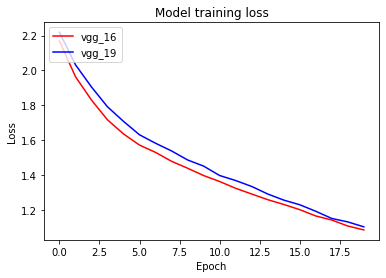

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

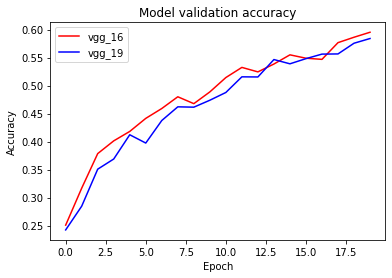

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()